# TL MMM White Paper -- Building and Validating MMM

In [1]:
import pandas as pd
import numpy as np
# set random seed
np.random.seed(11)

import matplotlib.pyplot as plt

%matplotlib inline  

# 0. Helper Functions

### 0.0 Functions for transforming input data frame

In [2]:
def lagp(x, p):
    x = list(x)

    if p >= 0:
        a = np.array([0] * p + x[0:len(x) - p])

    if p < 0:
        a = np.array(x[0 - p:len(x) - p] + [0] * (-p))
    return a

def transform_exp(x, alpha, lags):
    
    result = x.copy()
    sumWeight = 1
    ones = np.ones(len(result))
    for i in range(0,lags+1):
        result += alpha**i * lagp(x, i)
        sumWeight +=ones * alpha**i
    result = result/sumWeight
    return result



def transform_df(raw_data, transform_dict):
    transformed_df, mc_transformed_df = raw_data.copy(), raw_data.copy()

    for col in channels:
        transformed_df[col] = np.log(
            transform_exp(transformed_df[col], transform_dict['lag_alpha'][col], transform_dict['lag_length'][col])/
            transform_dict['scalars'][col] + 1)
        
        mc_transformed_df[col] = np.log(
            transform_exp(mc_transformed_df[col]+1, transform_dict['lag_alpha'][col], transform_dict['lag_length'][col])/
            transform_dict['scalars'][col] + 1)
    
    transformed_df['acqs'] = np.log(transformed_df['acqs']+1)
    
    return transformed_df, mc_transformed_df
        

### 0.1 Functions using R BSTS package

I am familiar with the BSTS R package for time series regressions so I pull in the R packages and execute in Python, but another Python package could be used instead.

In [3]:
# Load in python libraries to use R
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

# Load in R libraries 
pandas2ri.activate()
base = importr("base")
bsts = importr("bsts")

In [4]:
# Define function in R to generate model
ro.r('''
        build_model <- function(train_df) {
            
            y = train_df$acqs
            
            # Initialize state specification
            ss <- AddLocalLinearTrend(list(),y) 
            ss <- AddSeasonal(ss, y, nseasons = 7) # day of week

            # Set priors for betas
            size = dim(train_df)[2] 
            prior_spikes <- rep(1, size)
            prior_sd <- c(rep(1,size))
            prior_beta <- rep(0, size) 

            x_mat = model.matrix(acqs ~ ., data=train_df)
            prior <- IndependentSpikeSlabPrior(x = x_mat,
                                             y = y,
                                             prior.beta.sd = prior_sd,
                                             optional.coefficient.estimate = prior_beta,
                                             prior.inclusion.probabilities = prior_spikes)
            
            # create bsts model
            model <- bsts(formula = acqs ~ .,
                           state.specification = ss, 
                           data = train_df,
                           niter = 3000,
                           prior = prior,
                           seed = 2018,
                           ping = 0)
                           
            return(model)
        }
        ''')

r_build_model = ro.globalenv['build_model']

### 0.2 Functions for analyzing model

In [5]:
def get_components(r_model, burn, dates):
    # get the trend, day of week seasonality, and regression components by day
    components = {}
    components['Trend'] = np.array(r_model.rx('state.contributions')[0])[burn:,0,:].mean(axis = 0)
    components['Day_of_Week'] = np.array(r_model.rx('state.contributions')[0])[burn:,1,:].mean(axis = 0)
    components['Regression'] = np.array(r_model.rx('state.contributions')[0])[burn:,2,:].mean(axis = 0)
    components['Date'] = dates
    return pd.DataFrame(components)

def plot_components(components):
    # plot the trend, day of week seasonality, and regression components by day
    f, axes = plt.subplots(3, 1, figsize=(15,5))
    for c, i in enumerate(axes):
      axes[c].plot(components['Date'], components.iloc[:,c+1].values)
      axes[c].set_title(components.columns[c+1])
    plt.tight_layout()
    plt.show()

def back_test_model(model, holdout_data, actual_acqs, dates, burn, plot = True, q=[0.05, 0.95]):
    # back test the model for a holdout period 
    
    # put quantiles into R
    q = ro.FloatVector(q)
    # get prediction
    p_bt = bsts.predict_bsts(model, newdata = holdout_data, quantiles = q, seed = 2019) 
    
    bt_res = pd.DataFrame({'Predicted':np.exp(list(p_bt.rx('mean')[0])), 'Actual':actual_acqs,
                          'Date':dates})
    bt_res['abs_pct_error'] = np.abs(bt_res['Actual'] - bt_res['Predicted'])/bt_res['Actual']

    if plot == True:
        bt_res.set_index('Date')[['Actual','Predicted']].plot(
            color = ['#82adc6','#42491d'],style = ['-', '--'], figsize = (15,2), linewidth = 2.5)
        plt.title('Back Test on Preprocessing Scheme '+ str(t[-1]))
        plt.ylabel('Acquistions')
        plt.xlabel('Date')
        plt.show()

    daily_mape = bt_res['abs_pct_error'].mean()
    total_period_error = (bt_res['Predicted'].sum()-bt_res['Actual'].sum())/bt_res['Actual'].sum()
    
    return bt_res, daily_mape, total_period_error

def get_coefficients(r_model):
    # get the coefficients from the r model
    coefficients = np.array(r_model.rx('coefficients')[0])[burn:, ].mean(axis=0)[1:].reshape(1, -1)
    coefficients = {'channel_'+str(i+1):coefficients[0][i] for i in range(len(coefficients[0]))} 
    return coefficients


def get_regression_component(coefficients, input_df):
    # get the regression components 
    return np.array([(input_df[c]*coefficients[c]).values for c in coefficients]).sum(axis = 0)


def get_acquisitions(all_components, reg_component):
    # get the number of acquisitions 
    return np.exp(all_components['Trend'].values + all_components['Day_of_Week'].values + reg_component)


def get_avg_and_marginal_costs(start, end, components, coefficients):
    # get the average and marginal costs by channel for a given start and end date
    cpias = []
    mcs = []
    
    model_components = components.loc[(components['Date']>=start)& (components['Date']< end)]
    baseline_transformed_spend  = transformed_df.loc[(transformed_df['date']>= start )& (transformed_df['date']< end)]
    marginal_transformed_spend = mc_transformed_df.loc[(mc_transformed_df['date']>=start)& (mc_transformed_df['date']<end)]
    
    baseline_regression = get_regression_component(coefficients, baseline_transformed_spend)
    baseline_acqs = get_acquisitions(model_components, baseline_regression)
    
    for c in channels:

        month_spend_channel = input_df.loc[(input_df['date'] >= start) & (input_df['date'] < end)][c].values
        month_spend_channel_frac = month_spend_channel/month_spend_channel.sum()

        zero_channel_spend = baseline_transformed_spend.copy()
        zero_channel_spend[c] = 0
        zero_spend_regression = get_regression_component(coefficients, zero_channel_spend)
        zero_spend_acqs = get_acquisitions(model_components, baseline_regression) - get_acquisitions(model_components, zero_spend_regression)
        cpia =  month_spend_channel.sum()/zero_spend_acqs.sum()
        cpias.append(round(cpia,2))
        

        marg_month_spend = baseline_transformed_spend.copy()
        marg_month_spend[c] = marginal_transformed_spend[c]

        mc1 = get_regression_component(coefficients, marg_month_spend)
        month_marg_cost = (1/(get_acquisitions(model_components, mc1)-baseline_acqs) * month_spend_channel_frac).sum()
        mcs.append(round(month_marg_cost,2))

        
    res = pd.DataFrame({'Channels':channels, 'Average Cost Per Incremental Order': cpias, 'Marginal Cost': mcs}).set_index('Channels')
    return res


## 1. Build Media Mix Model (MMM)

### 1.1 Input data and potential transforms

In [6]:
#Load toy data generated from 0_TL_Whitepaper_Companion_Code_Data_Generatation.ipynb
input_df = pd.read_csv('spend_and_acquisitions_data.csv', parse_dates = ['date'], index_col = 0)
channels = [c for c in input_df.columns if 'channel' in c]

In [7]:
# trying out different transformations of data

transform_1 = {
    'scalars':{'channel_1':1, 'channel_2':1, 'channel_3':1, 'channel_4':1},
    'lag_length': {'channel_1':7, 'channel_2':7, 'channel_3':7, 'channel_4':7},
    'lag_alpha': {'channel_1':0.5, 'channel_2':0.5, 'channel_3':0.5, 'channel_4':0.5}
}

transform_2 = {
    'scalars':{'channel_1':5000, 'channel_2':5000, 'channel_3':5000, 'channel_4':5000},
    'lag_length': {'channel_1':0, 'channel_2':0, 'channel_3':0, 'channel_4':0},
    'lag_alpha': {'channel_1':0, 'channel_2':0, 'channel_3':0, 'channel_4':0}
}


transform_3 = {
    'scalars':{'channel_1':15000, 'channel_2':15000, 'channel_3':15000, 'channel_4':5000},
    'lag_length': {'channel_1':4, 'channel_2':0, 'channel_3':4, 'channel_4':0},
    'lag_alpha': {'channel_1':0.5, 'channel_2':0, 'channel_3':0.5, 'channel_4':0}
}



### 1.2 Build Models and Get Results

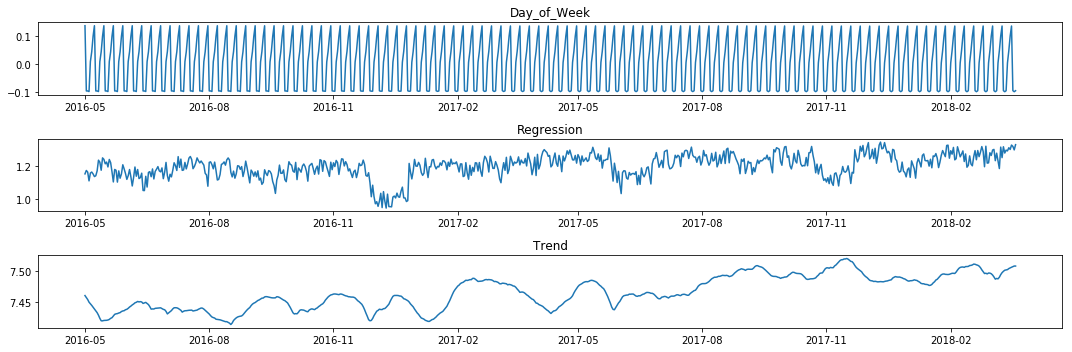

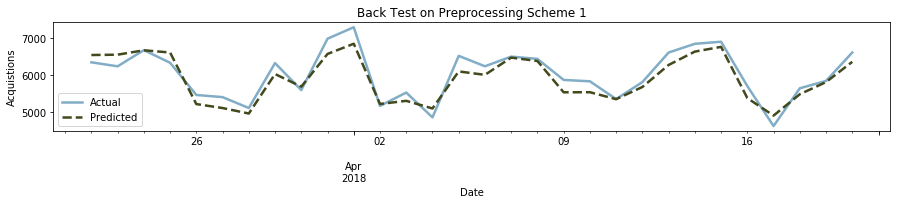

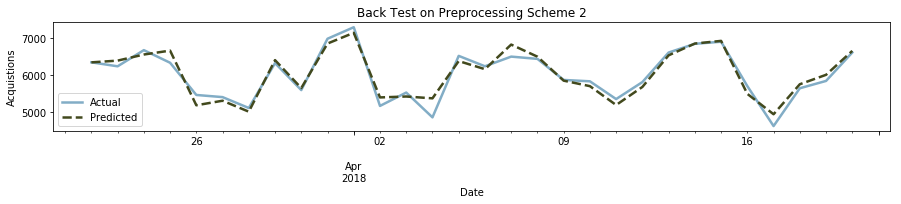

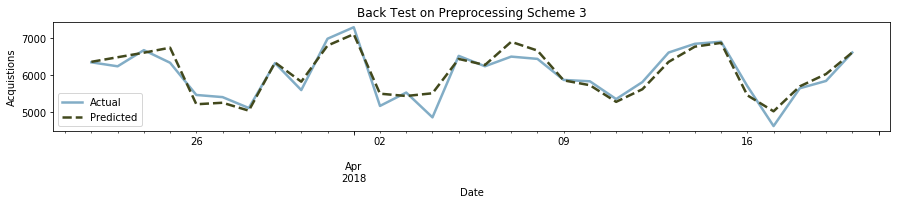

In [8]:
find_costs_start, find_costs_end = '2017-10-01', '2017-10-21'
bt_length = 30
res_columns = ['Transform', 'Backtest - Daily MAPE'] + \
                ['Channel '+str(i+1)+' - CPIA' for i in range(len(channels))] + \
                ['Channel '+str(i+1)+' - MCPA' for i in range(len(channels))]
models_res = pd.DataFrame(columns =res_columns)

for t in ['transform_1', 'transform_2', 'transform_3']:
    
    # get transformed data frames for train and test
    transformed_df, mc_transformed_df = transform_df(input_df, eval(t))
    bt_train_df_R = pandas2ri.py2ri(transformed_df[channels + ['acqs']][0:-bt_length])
    bt_test_df_R = pandas2ri.py2ri(transformed_df[channels][-bt_length:])

    # train model 
    r_model_bt = r_build_model(bt_train_df_R)
    # get burn to know how many MCMC samples to throw away
    burn = int(bsts.SuggestBurn(0.1, r_model_bt)[0])
    
    # get model components -
    components = get_components(r_model_bt, burn, transformed_df['date'][0:-bt_length])
    
    if t =='transform_1':
        plot_components(components)
    
    # do backtest and get results
    bt_res_table, daily_mape, total_error = back_test_model(
        r_model_bt, bt_test_df_R, input_df.acqs[-bt_length:], transformed_df['date'][-bt_length:].values, burn)
    
    coefficients = get_coefficients(r_model_bt)
    costs_res = get_avg_and_marginal_costs(find_costs_start, find_costs_end, components, coefficients)
    
    res_row = [t, round(daily_mape,3)] + list(costs_res.values[:,0])+list(costs_res.values[:,1])
    
    models_res = models_res.append(pd.DataFrame(np.array(res_row).reshape(1,-1),columns = res_columns))
    
   
    

In [9]:
# results for when find_costs_start, find_costs_end = '2017-10-01', '2017-10-21'
models_res

,Transform,Backtest - Daily MAPE,Channel 1 - CPIA,Channel 2 - CPIA,Channel 3 - CPIA,Channel 4 - CPIA,Channel 1 - MCPA,Channel 2 - MCPA,Channel 3 - MCPA,Channel 4 - MCPA
0,transform_1,0.036,10.66,14.8,10.12,22.22,119.34,138.19,106.64,213.51
0,transform_2,0.025,57.96,57.14,40.56,137.34,88.96,172.8,94.03,215.38
0,transform_3,0.031,45.3,71.03,35.61,120.79,53.79,149.32,55.86,189.34
